
# Data Preprocessing
In this notebook we load and process the raw data to develop the final dataset for the IBM-Z Datathon. We make use of two main datasets for a list of all observed geoeffective CMEs from the post-SOHO era between 1996-2024, and two data sets for features and targets:

#### Geo-effective CMEs Targets:
- The [Richardson and Cane list](https://izw1.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm); a list of near-Earth CMEs from 1996-2024.
- The [George Mason University CME/ICME list](http://solar.gmu.edu/heliophysics/index.php/GMU_CME/ICME_List); a list of geoeffective CMEs from 2007-2017.

#### CME Features:
- The [SOHO-LASCO CME Catalogue](https://cdaw.gsfc.nasa.gov/CME_list/); a list of all CMEs observed from 1996-2024 containing information on physical quantities.
- [OMNIWeb Plus data](https://omniweb.gsfc.nasa.gov/); a list of features associated with the solar wind and sunspot numbers.

We will proceed by cleaning and combining the datasets to obtain and final set of features and targets. We will then explore the final dataset to make some conclusions.


## Cleaning the data:

In [2]:
# Importing libraries:
# For data manipulation and testing
import pandas as pd
import numpy as np
from datetime import timedelta
import scipy.stats as stats
from scipy.stats import normaltest

# For data visualisation
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler


In [3]:
# Adding filepaths as variables
cane_file_path = r"data/Raw Data/RichardsonCane.csv"
gmu_file_path = r"data/Raw Data/GMU.csv"
soho_file_path = r"data/Raw Data/SOHO_LASCO.csv"
omniweb_file_path = r"data/Raw Data/OMNIWeb.csv"


#### SOHO-LASCO Catalogue

We begin by loading in the SOHO-LASCO Catalogue to obtain the physical quantities for all CMEs. The original dataset had 11 total features. Most of the data was missing for the mass and kinetic energy hence these have been excluded. We have also excluded the second-order speeds as these are correlated with the linear speed. As a result this dataset contains the dates and times for each CME, together with five features:
- Central Position Angle in degrees.
- Angular Width in degrees.
- Linear Speed in km/s.
- Acceleration in km/s$^2$.
- Measurement Position Angle in degrees.


After inspecting the dataset, we will do the following:
- Convert all missing values labelled as "------" and "NaN" to `None`.
- Convert Central PA values labelled as "Halo" to 360.
- Reformat the Acceleration column by removing asterisks.
- Convert all columns to numeric.
- Remove CME data corresponding to an angular width below 90 degrees as it is known that these are not likely to be geoeffective.
- Replace labelled columns "Date" and "Time" with a single "Datetime" column.

In [4]:
# Reading the SOHO-LASCO Dataset
soho_df = pd.read_csv(soho_file_path)

# Replace all missing values ('------' and 'NaN') with None
soho_df.replace(['------', 'NaN'], None, inplace=True)

# Convert Angular Width values labelled as "Halo" to 360
soho_df['CentralPA'] = soho_df['CentralPA'].replace('Halo', 360)

# Remove asterisks from the Acceleration column
soho_df['Accel'] = soho_df['Accel'].astype(str).str.replace('*', '', regex=False)

# Convert all columns to numeric, except the first two (Date and Time)
cols_to_convert = soho_df.columns[2:]  # Keep first two columns (Date and Time) as object
soho_df[cols_to_convert] = soho_df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

# Remove rows where Central PA is below 90 degrees
soho_df = soho_df[soho_df['AngularWidth'] >= 90]

# Combine first two columns
soho_df['Datetime'] = pd.to_datetime(soho_df['Date'] + ' ' + soho_df['Time'], dayfirst=True) # Creating Datetime column
soho_df = soho_df.drop(soho_df.columns[[0, 1]], axis=1) # Drop the first two columns by index
last_column = soho_df.pop(soho_df.columns[-1])  # Pop the last column
soho_df.insert(0, last_column.name, last_column)  # Insert it at the front

#### OMNIWeb Plus Dataset
To obtain the final list of features, we must concatenate the SOHO-LASCO Catalogue with the OMNIWeb Plus Dataset. This dataset contains 12 features associated with the solar wind:

- The X-component of the magnetic field in nT.
- The Y-component of the magnetic field in nT.
- The Z-component of the magnetic field in nT.
- Plasma Temperature in Kelvin.
- Solar Proton Density n/cc.
- Flow Speed in km/s.
- Longitude Angle in degrees.
- Latitude Angle in degrees.
- Proton Density Ratio (unitless).
- Flow Pressure in nPa.
- Plasma Beta (unitless).
- Sunspot Number.

After taking a look at the OMNIWeb Plus Data, we next to the following to the dataset:
- Reformat first column to match the SOHO-LASCO data.
- Match times by averaging the 6-hour window after CME ejection.
- Concatenate both datasets to obtain final list of all 17 features.

In [5]:
# Reading the OMNIWeb Plus Dataset
omniweb_df = pd.read_csv(omniweb_file_path)

# Reformat Datetime column
omniweb_df['Datetime'] = pd.to_datetime(omniweb_df['Datetime'] + ':00', dayfirst=True)

replacement_values = [9999, 99, 999, 999.9, 9999999., 9999., 99.99, 9.999, 999.99, 999] # Removing unavailable data
omniweb_df.replace(replacement_values, None, inplace=True)

# Define a function to get the 6-hour averaged data after each CME
def get_solar_wind_average(cme_time, omniweb_data, window_hours=6):
    # Get the end time for the 6-hour window
    end_time = cme_time + pd.Timedelta(hours=window_hours)

    # Filter OMNIWeb data for the 6-hour window
    filtered_omniweb = omniweb_data[(omniweb_data['Datetime'] >= cme_time) & (omniweb_data['Datetime'] <= end_time)]

    # Calculate the average of all numerical columns in this window
    return filtered_omniweb.mean()

# Apply this function to each CME in the Cane dataset
averaged_solar_wind = soho_df['Datetime'].apply(get_solar_wind_average, omniweb_data=omniweb_df)

# Combine the averaged solar wind features with the original Cane dataset
combined_df = pd.concat([soho_df, averaged_solar_wind], axis=1)
combined_df.columns.values[6] = 'Datetime_2' # Renaming duplicated column

features_df  = combined_df.drop('Datetime_2', axis=1) # Removing duplicated Datetime column

#### Richardson and Cane Dataset
After manually removing irrelevant columns, the Cane dataset contain three column corresponding to the targets that will be used to train our models:
- LASCO CME Time.
- Disturbance Time.
- Dst Index measured in nT.


After inspection, we will do the following:
- Convert the first two column to the correct datetime format.
- Remove CMEs with a Dst index greater than -30 nT and label CMEs with a Dst index of less  as Geoeffective.
- Calculate the transit time as the difference between the LASCO CME time and the Disturbance time and convert to hours.


In [6]:
# Reading the Richardson-Cane Dataset
cane_df = pd.read_csv(cane_file_path)

# Reformatting the first two columns
cane_df['LASCO CME Y/M/D (UT)'] = pd.to_datetime(cane_df['LASCO CME Y/M/D (UT)'], format='mixed')
cane_df['Disturbance Y/M/D (UT)'] = pd.to_datetime(cane_df['Disturbance Y/M/D (UT)'], format='mixed')

# Dropping CMEs with a Dst index greater than -30 nT
cane_df = cane_df[cane_df['Dst (nT)'] <= -30]

# Calculating transit time
cane_df['TransitTime'] = cane_df['Disturbance Y/M/D (UT)'] - cane_df['LASCO CME Y/M/D (UT)']

# Dropping CMEs with a transit time of 0
cane_df = cane_df[cane_df['TransitTime'].dt.total_seconds() > 0]

# Converting transit time to hours as a float
cane_df['TransitTime'] = cane_df['TransitTime'].dt.total_seconds() / 3600

# Labelling and creating Geoeffective column (positive class labelled as 1)
cane_df['Geoeffective'] = 1
cane_df = cane_df.drop(cane_df.columns[[1, 2]], axis=1)

#### George Mason University Dataset
The GMU dataset contains similar information to the Cane dataset, however, the CMEs are recorded from 2007-2017. The formatting is inconsistent so we will do the following:
- Convert transit time column to delta-time format.
- Concert transit time to hours as a float.


In [7]:
# Reading the GMU dataset
gmu_df = pd.read_csv(gmu_file_path)

# Formating transit time column
gmu_df['Transit time'] = pd.to_timedelta(gmu_df['Transit time'])

# Converting transit time to hours
gmu_df['Transit time'] = gmu_df['Transit time'].dt.total_seconds() / 3600

In [8]:
# Saving cleaned .csv files
#gmu_df.to_csv(r"data/cleaned_gmu.csv", index=False)
#cane_df.to_csv(r"data/cleaned_cane.csv", index=False)

## Merging all Datasets:
To merge the features dataset with the Cane and GMU dataset we will do the following:
- Reformat all columns to maintain consistency.
- Concatenate the Cane and GMU datasets and remove duplicate events.
- Set an epsilon window to iterate over each geoeffective event and match with the LASCO datetimes.

In [9]:
# Convert the datetime columns to a consistent format for merging
features_df['Datetime'] = pd.to_datetime(features_df['Datetime'])
cane_df['LASCO CME Y/M/D (UT)'] = pd.to_datetime(cane_df['LASCO CME Y/M/D (UT)'])
gmu_df['CME in LASCO'] = pd.to_datetime(gmu_df['CME in LASCO'])

# Rename columns for consistency
cane_df.rename(columns={'LASCO CME Y/M/D (UT)': 'Datetime'}, inplace=True)
gmu_df.rename(columns={'CME in LASCO': 'Datetime'}, inplace=True)

# Merge the cleaned_cane and cleaned_gmu datasets together
geoeffective_df = pd.concat([cane_df, gmu_df])

# Remove duplicate CMEs from the combined geoeffective dataframe based on the datetime
geoeffective_df = geoeffective_df.drop_duplicates(subset='Datetime')

# Set an epsilon time window (e.g., +/- 0.5 hours)
epsilon = timedelta(hours=0.5)

# Create new columns for Geoeffective and TransitTime with default values
merged_df = features_df.copy()
merged_df['Geoeffective'] = 0
merged_df['TransitTime'] = None

# Iterate over each geoeffective event and match with the features within the epsilon window
for _, row in geoeffective_df.iterrows():
    cme_datetime = row['Datetime']

    # Find matches within the epsilon window
    mask = (merged_df['Datetime'] >= cme_datetime - epsilon) & (merged_df['Datetime'] <= cme_datetime + epsilon)
    merged_df.loc[mask, 'Geoeffective'] = 1
    merged_df.loc[mask, 'TransitTime'] = row['TransitTime']

merged_df['TransitTime'] = pd.to_numeric(merged_df['TransitTime'], errors='coerce')
# Saving the final dataset as .csv
#merged_df.to_csv(r"data/final_dataset.csv", index=False)

## Data Exploration and Visualisation
Let us now explore the data to make some conclusions and discuss its potential impact. We will do the following:
- Inspect the distribution of the positive and negative classes.
- Inspect the distribution of the regression target.
- Examine and mitigate the impact of missing values.
- Feature selection using F-score and Mutual Information.
- Inspect the feature space with Uniform Manifold Approximation and Projection (UMAP).

#### Inspecting the Target Distributions
We will begin by taking a look at the positive and negative classes:

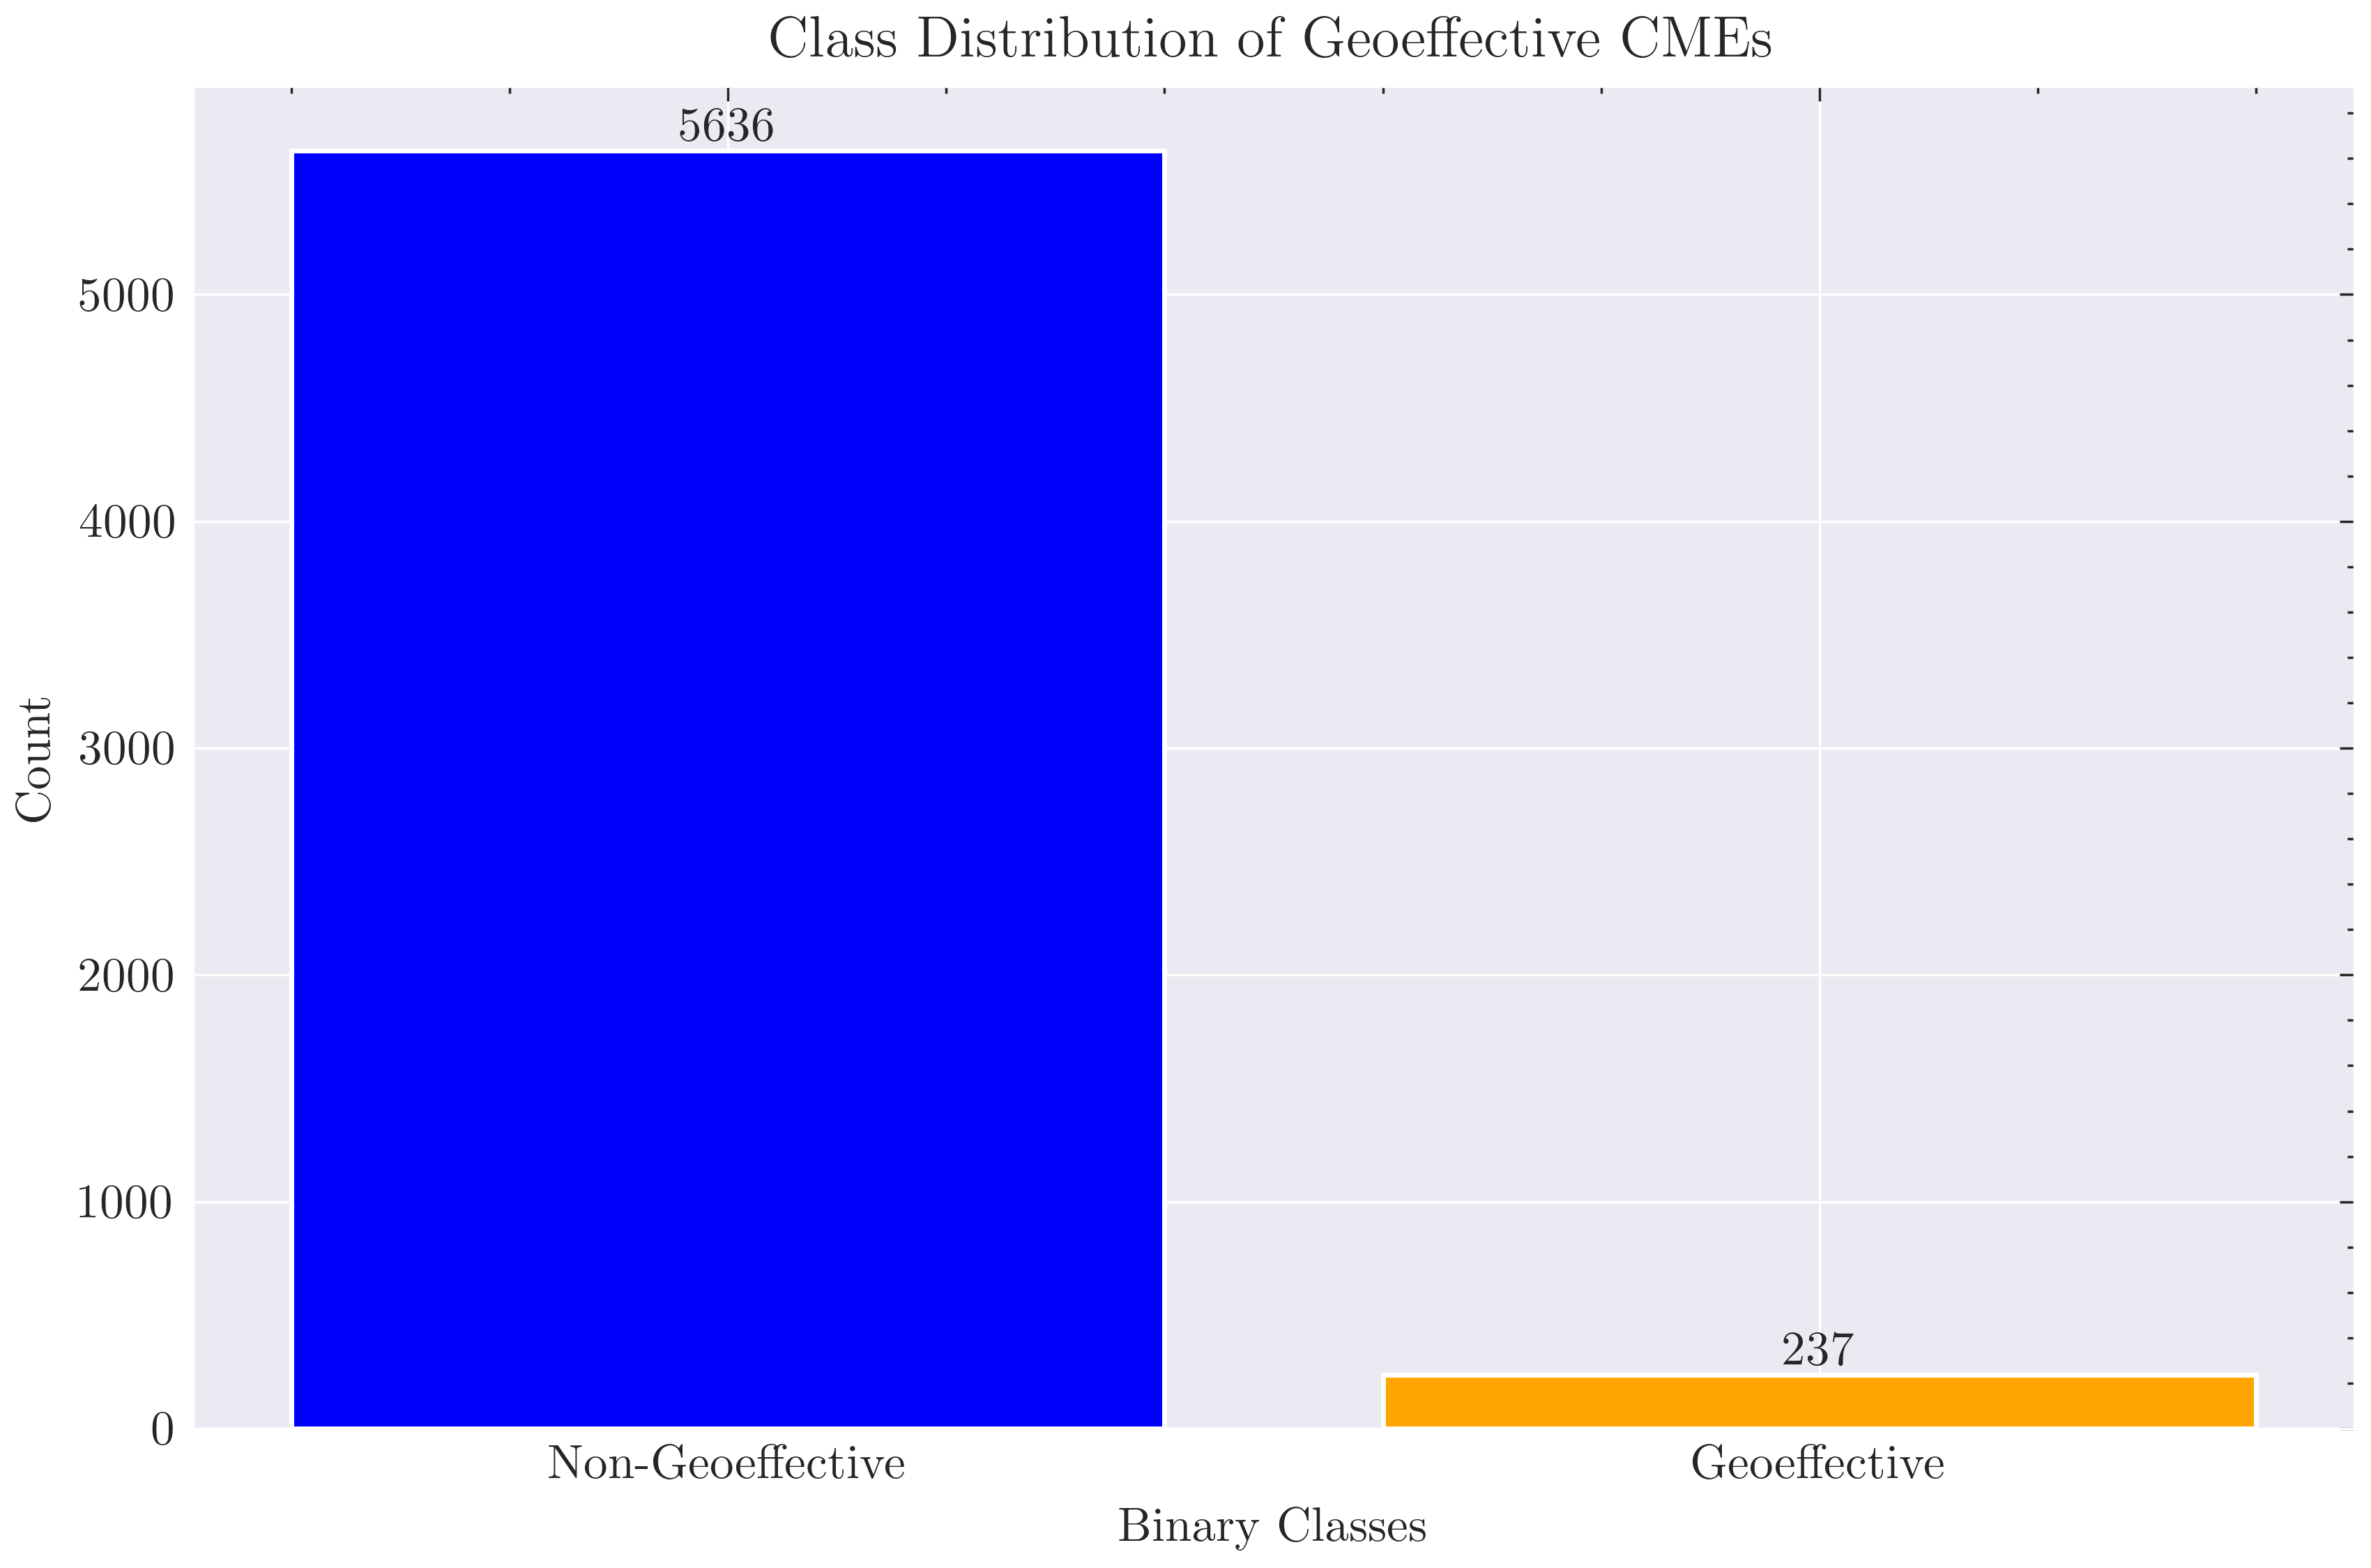

In [10]:
# Calculate the counts of each class
class_counts = merged_df['Geoeffective'].value_counts()

# Create a bar chart
plt.style.use(['science'])
plt.figure(figsize=(8,5), dpi=500)
bars = plt.bar(class_counts.index, class_counts.values, color=['blue', 'orange'])

# Add labels on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

# Add titles and labels
plt.title('Class Distribution of Geoeffective CMEs')
plt.xlabel('Binary Classes')
plt.ylabel('Count')
plt.xticks([0, 1], ['Non-Geoeffective', 'Geoeffective'])
plt.show()

Note here that the positive class makes up roughly 4% of the data. Next we will have a look at the transit times:

In [11]:
# Summary statistics for TransitTime
skewness = merged_df['TransitTime'].skew()
kurtosis = merged_df['TransitTime'].kurtosis()
print(f'Skewness   {skewness:.6f}')
print(f'Kurtosis  {kurtosis:.6f}')
print(merged_df['TransitTime'].describe())

Skewness   0.188469
Kurtosis  -0.538147
count    195.000000
mean      63.727778
std       19.640075
min       18.683333
25%       48.875000
50%       64.100000
75%       78.366667
max      112.000000
Name: TransitTime, dtype: float64


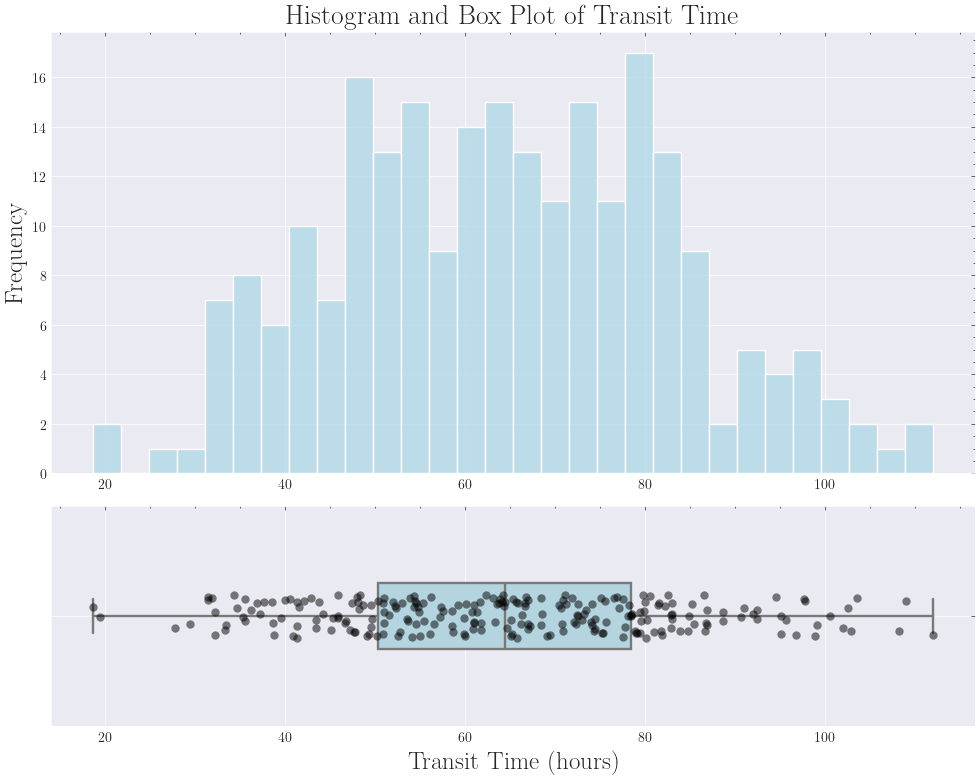

In [19]:
# Set up the figure with two subplots, one for the histogram and one for the box plot
fig, (ax_hist, ax_box) = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 0.5]})

# 1. Plot the histogram of TransitTime on the top subplot
sns.histplot(merged_df['TransitTime'], bins=30, kde=False, ax=ax_hist, color='lightblue')
ax_hist.set_title('Histogram and Box Plot of Transit Time', fontsize=20)
ax_hist.set_xlabel('')
ax_hist.set_ylabel('Frequency', fontsize=18)

# 2. Plot the box plot of TransitTime horizontally on the bottom subplot
sns.boxplot(x='TransitTime', data=merged_df, color='lightblue', ax=ax_box, width=0.3, linewidth=1.7)
sns.stripplot(x='TransitTime', data=merged_df, color='black', jitter=True, alpha=0.5, size=6, ax=ax_box)

# 3. Remove the x-label from the histogram to avoid repetition
ax_box.set_xlabel('Transit Time (hours)', fontsize=18)

# Adjust layout for better spacing
plt.grid(True)
plt.tight_layout()
plt.show()

Having a look at the data we can conclude that the transit time for CMEs is generally consistent with current estimates, with most values between 48.88 and 78.37 hours. The data is nearly symmetrically distributed around the mean of 63.73. There are no significant outliers or extreme values, as indicated by the small negative kurtosis. The mild positive skew suggests that while there are a few CMEs with higher transit time, most of the data is concentrated on the mean. Lets try a Q-Q plot:


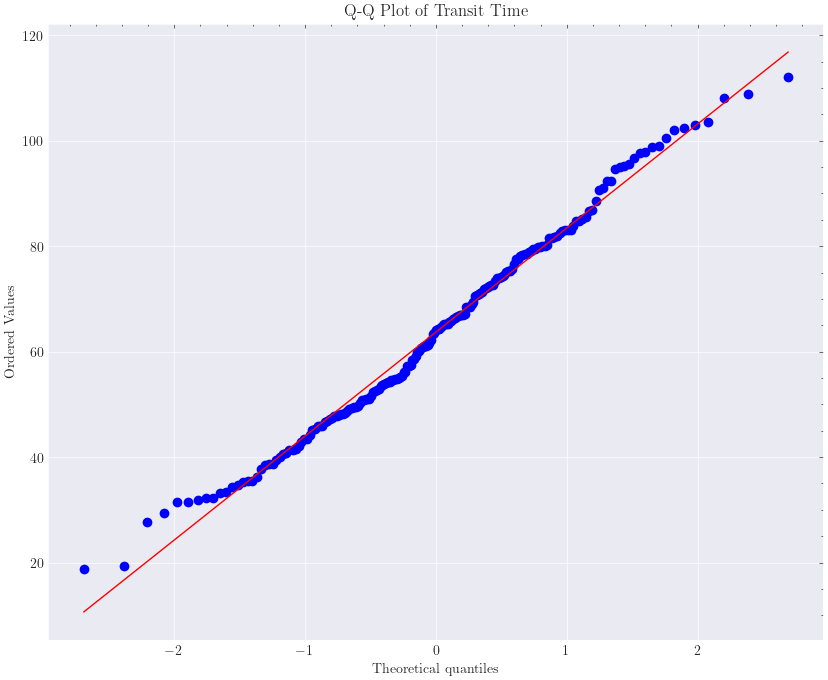

In [13]:
# Q-Q plot to check for normality
plt.figure(figsize=(10, 8)) 
stats.probplot(merged_df['TransitTime'].dropna(), dist="norm", plot=plt)
plt.title('Q-Q Plot of Transit Time')
plt.show()

#### Assessing the Impact of Missing Values
We need to do two separate analyses of missing values as the transit time column is mostly missing values (as it should be) and combine the data to form a single plot:
- Percentage of missing values in features for all CMEs.
- Percentage of missing values in transit time corresponding to `Geoeffective = 1`.

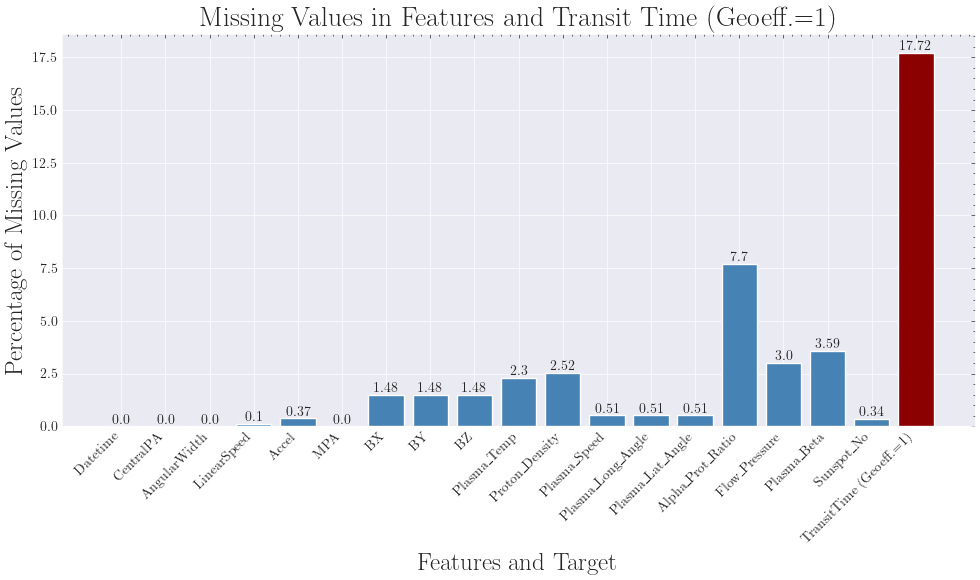

In [14]:
# Calculate missing values in the features_df
missing_values_features = features_df.isnull().sum()
missing_percentage_features = (missing_values_features / len(features_df)) * 100

# Calculate missing values in 'TransitTime' for Geoeffective = 1
geoeffective_1 = merged_df[merged_df['Geoeffective'] == 1]  # Filter Geoeffective = 1
missing_transit_time_geoeff_1 = geoeffective_1['TransitTime'].isnull().sum()
missing_percentage_transit_time_geoeff_1 = (missing_transit_time_geoeff_1 / len(geoeffective_1)) * 100

# Combine the two sets of data into one for plotting
combined_labels = list(missing_percentage_features.index) + ['TransitTime (Geoeff.=1)']
combined_values = list(missing_percentage_features) + [missing_percentage_transit_time_geoeff_1]

# Plot the combined data
plt.figure(figsize=(10, 6))
bars = plt.bar(combined_labels, combined_values, color=['steelblue'] * len(missing_percentage_features) + ['darkred'])

# Add labels and title
plt.title('Missing Values in Features and Transit Time (Geoeff.=1)', fontsize=20)
plt.xlabel('Features and Target', fontsize=18)
plt.ylabel('Percentage of Missing Values', fontsize=18)
plt.xticks(rotation=45, ha='right')

# Display the values on top of the bars for clarity
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

We could drop all missing values and process with our modelling, however, this would further decrease our already small positive class. Instead, we will impute missing values using two distinct methods:

- As the percentage of missing values are quite small for the features we will use sklearn's `KNNImputer`. We will first have to examine the normality of each of the features to determine transformations which kind of scaling to use; either `StandardScaler` or `MinMaxScaler`. We will do this by examining the histograms and Q-Q plots for normality for each feature.

- As the transit time has a relatively large amount of missing values we shall use a random forest imputer. This method will iteratively refine the imputation based on the interactions between transit time and other features, making it effective for large amounts (10-30%) of missing data.

#### Imputing Missing Features with KNNImputer
We will proceed by doing the following:
- Remove Datetime column.
- Each feature is scaled using either StandardScaler (for normally distributed features) or MinMaxScaler (for non-normally distributed features) with or without log transformations based on the results of the plotting a histogram and Q-Q plot.
- After scaling, KNNImputer is applied to fill the missing values based on the nearest neighbors of each data point.
- After imputation, each feature is rescaled back to its original values using the inverse_transform() method of the scaler that was originally applied. This step restores the features to their original units and scale, making them interpretable again.


In [15]:
# Remove datetime columns and separate numerical features
datetime_columns = features_df.select_dtypes(include=['datetime', '<M8[ns]']).columns
numerical_features_df = features_df.drop(columns=datetime_columns)

# The following is commented out as it will generate 34 plots:
# Plot histogram and Q-Q plots for each feature
# for column in numerical_features_df.columns:
#     plt.figure(figsize=(6, 4))
#     sns.histplot(numerical_features_df[column].dropna(), kde=True)
#     plt.title(f'Histogram of {column}')
#     plt.show()
# 
#     # Q-Q plot to check for normality
#     plt.figure(figsize=(6, 4))
#     stats.probplot(numerical_features_df[column].dropna(), dist="norm", plot=plt)
#     plt.title(f'Q-Q Plot of {column}')
#     plt.show()

After inspecting the histograms and Q-Q plots we will apply the following transformations and scaling to each feature:

| **Feature**             | **Optimal Scaler**    | **Transformation**               | **Reason**                                              |
|-------------------------|-----------------------|-----------------------------------|---------------------------------------------------------|
| **CentralPA**            | MinMaxScaler          | None                              | Bimodal distribution, not normal.                       |
| **AngularWidth**         | MinMaxScaler          | None                              | Right skewed, highly concentrated at lower values.       |
| **LinearSpeed**          | MinMaxScaler          | None                              | Strong right skewness.                                  |
| **Accel**                | MinMaxScaler          | None                              | Strong peak with limited variance.                      |
| **MPA**                  | MinMaxScaler          | None                              | Bimodal, non-normal distribution.                       |
| **BX**                   | MinMaxScaler          | None                              | Double-peaked distribution, non-normal.                 |
| **BY**                   | MinMaxScaler          | None                              | Double-peaked distribution, non-normal.                 |
| **BZ**                   | MinMaxScaler          | None                              | Double-peaked distribution, slight deviation from normal.|
| **Plasma_Temp**          | MinMaxScaler          | Log Transform                     | Strong right skew, long tail.                           |
| **Proton_Density**       | MinMaxScaler          | Log Transform                     | Strong right skew, long tail.                           |
| **Plasma_Speed**         | MinMaxScaler          | None                              | Right skewed, long tail.                                |
| **Plasma_Long_Angle**    | MinMaxScaler          | None                              | Symmetric but moderate deviations from normality.        |
| **Plasma_Lat_Angle**     | MinMaxScaler          | None                              | Symmetric but moderate deviations from normality.        |
| **Alpha_Prot_Ratio**     | MinMaxScaler          | Log Transform                     | Strong right skew, long tail.                           |
| **Flow_Pressure**        | MinMaxScaler          | Log Transform                     | Very strong right skew, concentrated near 0.             |
| **Plasma_Beta**          | MinMaxScaler          | Log Transform                     | Very strong right skew, concentrated near 0.             |
| **Sunspot_No**           | MinMaxScaler          | None                              | Slight right skew, non-normal.                          |


In [16]:
# List of features that require log transformation
log_transform_features = ['Plasma_Temp', 'Proton_Density', 'Alpha_Prot_Ratio', 'Flow_Pressure', 'Plasma_Beta']

# Apply log transformation to selected features
for feature in log_transform_features:
    numerical_features_df[feature] = np.log1p(numerical_features_df[feature])  # log1p handles zero values safely

# Initialize MinMaxScaler for all numerical features
scaler = MinMaxScaler()

# List of all numerical features to scale (excluding datetime columns)
features_to_scale = numerical_features_df.columns  # This ensures all numerical features are scaled

# Fit the MinMaxScaler and transform the numerical data
scaled_numerical_data = scaler.fit_transform(numerical_features_df)

# Convert the scaled data back into a DataFrame
scaled_numerical_df = pd.DataFrame(scaled_numerical_data, columns=numerical_features_df.columns)

# Apply KNN imputation to handle missing values in the scaled data
knn_imputer = KNNImputer(n_neighbors=5)
imputed_scaled_data = knn_imputer.fit_transform(scaled_numerical_df)

# Convert imputed data back to DataFrame
imputed_scaled_df = pd.DataFrame(imputed_scaled_data, columns=numerical_features_df.columns)

# Now rescale the imputed data back to the original range
imputed_rescaled_df = pd.DataFrame(scaler.inverse_transform(imputed_scaled_df), columns=imputed_scaled_df.columns)

# Reverse the log transformation for the log-transformed features
for feature in log_transform_features:
    imputed_rescaled_df[feature] = np.expm1(imputed_rescaled_df[feature])  # expm1 reverses log1p

# Recombine imputed numerical data with the datetime columns
features_imputed_df = pd.concat([features_df[datetime_columns].reset_index(drop=True), imputed_rescaled_df.reset_index(drop=True)], axis=1)

#### Imputing Missing Transit Times with Random Forest
We will proceed by doing the following:
- Reset the indices of both features_imputed_df and merged_df to ensure alignment between the two DataFrames.
- Re-add the transit time and Geoeffective columns back to features_imputed_df after index alignment.
- Filter the data to identify rows where `Geoeffective == 1` and transit time is missing, as these are the events for which we will perform imputation.
- Separate the dataset into a training set (rows where transit time is not missing for Geoeffective events) and a prediction set (rows with missing transit time for Geoeffective events).
- Exclude datetime columns and the Geoeffective column from the training and prediction sets.
- Use a random forest regressor to predict the missing transit time values based on the non-missing data.
- Once predicted, the imputed values are assigned back to the original DataFrame for rows where `Geoeffective == 1`.
- Finally, the Geoeffective and transit time columns are reordered to place Geoeffective before transit time, ensuring a logical column structure. 

This ensures that only the missing transit time values for Geoeffective events are filled, while rows where `Geoeffective == 0` retain their missing transit time values.


In [17]:
# Reset index for both dataframes to ensure alignment
features_imputed_df.reset_index(drop=True, inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Add back `TransitTime` and `Geoeffective` from the original merged DataFrame
features_imputed_df['TransitTime'] = merged_df['TransitTime']
features_imputed_df['Geoeffective'] = merged_df['Geoeffective']

# Filter for rows where `Geoeffective == 1` and `TransitTime` is missing (these are the rows to impute)
geoeffective_missing = (features_imputed_df['Geoeffective'] == 1) & (features_imputed_df['TransitTime'].isnull())
missing_indices = features_imputed_df.loc[geoeffective_missing].index

# Separate the data into training set (non-missing TransitTime where Geoeffective = 1) and prediction set
df_notnull = features_imputed_df[(features_imputed_df['Geoeffective'] == 1) & (features_imputed_df['TransitTime'].notnull())]
df_null = features_imputed_df.loc[missing_indices]  # Rows where TransitTime is missing for Geoeffective = 1

# Define X_train, y_train, and X_null, excluding datetime columns and Geoeffective column
datetime_columns = features_imputed_df.select_dtypes(include=['datetime', '<M8[ns]']).columns
X_train = df_notnull.drop(columns=['TransitTime', 'Geoeffective', *datetime_columns])
y_train = df_notnull['TransitTime']
X_null = df_null.drop(columns=['TransitTime', 'Geoeffective', *datetime_columns])

# Train the RandomForestRegressor
rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42)
rf_imputer.fit(X_train, y_train)

# Predict missing TransitTime values
predicted_transit_time = rf_imputer.predict(X_null)

# Assign the predicted values to rows where Geoeffective == 1
features_imputed_df.loc[missing_indices, 'TransitTime'] = predicted_transit_time
merged_df.loc[missing_indices, 'TransitTime'] = predicted_transit_time

# Move 'Geoeffective' before 'TransitTime' explicitly
columns = list(features_imputed_df.columns)
columns.remove('Geoeffective')
columns.remove('TransitTime')
columns.append('TransitTime')
columns.insert(columns.index('TransitTime'), 'Geoeffective')

# Reorder the DataFrame columns
features_imputed_df = features_imputed_df[columns]

# Saving final imputed dataset to .csv
#features_imputed_df.to_csv(r'C:\Users\Yusuf\PycharmProjects\IBM-Z-Datathon-2024\data\final_imputed_dataset.csv', index=False)

#### Feature Selection and Inspection


## Discussion and Conclusions
We have at last obtained the final dataset on which to train our models. There are some important things to note which are discussed as follows:

<strong style="font-size:18px;">Class Imbalance:</strong> One of the most prominent issues is the extreme imbalance between geoeffective and non-geoeffective CMEs. We note that only about 4% of CMEs end up impacting Earth and causing geomagnetic storms. This skewed distribution will make it difficult for the models to effectively identify the minority class.

<strong style="font-size:18px;">Feature Selection:</strong> The success of CME prediction models heavily relies on the selection and representation of input features. Only solar onset (solar wind) parameters have been used, which limits the model’s ability to account for CME propagation in interplanetary space.

<strong style="font-size:18px;">Missing Values:</strong> Our final data set suffers from missing values. Eliminating data with missing values can further reduce the already small positive class size, making it even harder to train effective models. As such we have imputed missing values using the sklearn KNN Imputer.

<strong style="font-size:18px;">Class Overlap:</strong> There is substantial similarity between the features of geoeffective and non-geoeffective CMEs, leading to overlapping data points in feature space. This class overlap makes it hard for models to distinguish between the two classes and exacerbates misclassifications.

<strong style="font-size:18px;">Labelling Uncertainty:</strong> Due to the uncertain association between CMEs and geomagnetic storms, the models may sometimes be trained on inaccurate data. For instance, some storms might be caused by CMEs that are difficult to link definitively to solar eruptions, leading to uncertainty in labels. Another important note is that the data does not distinguish between front-facing and back-facing CMEs (i.e. CMEs facing towards Earth or away).
